## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

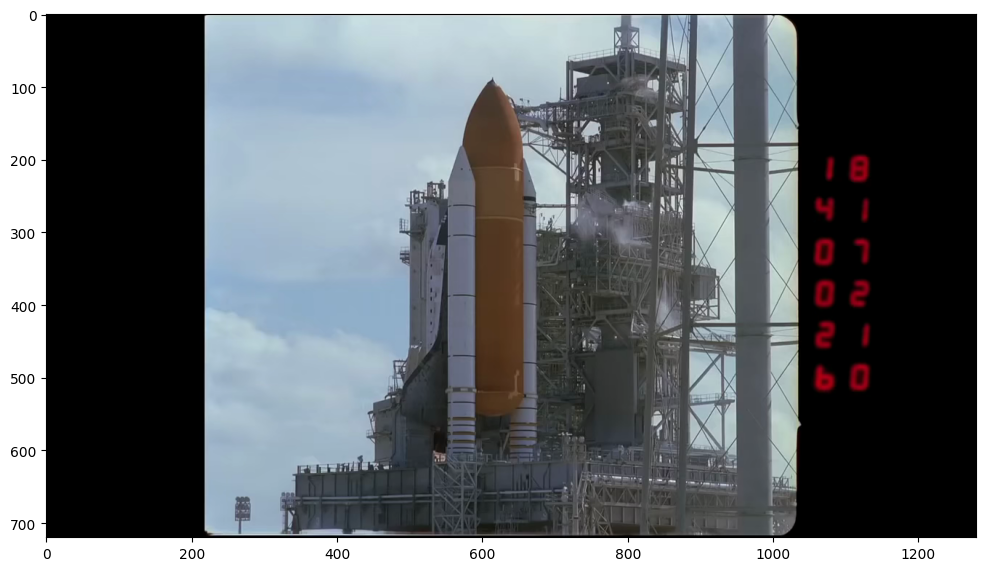

In [2]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

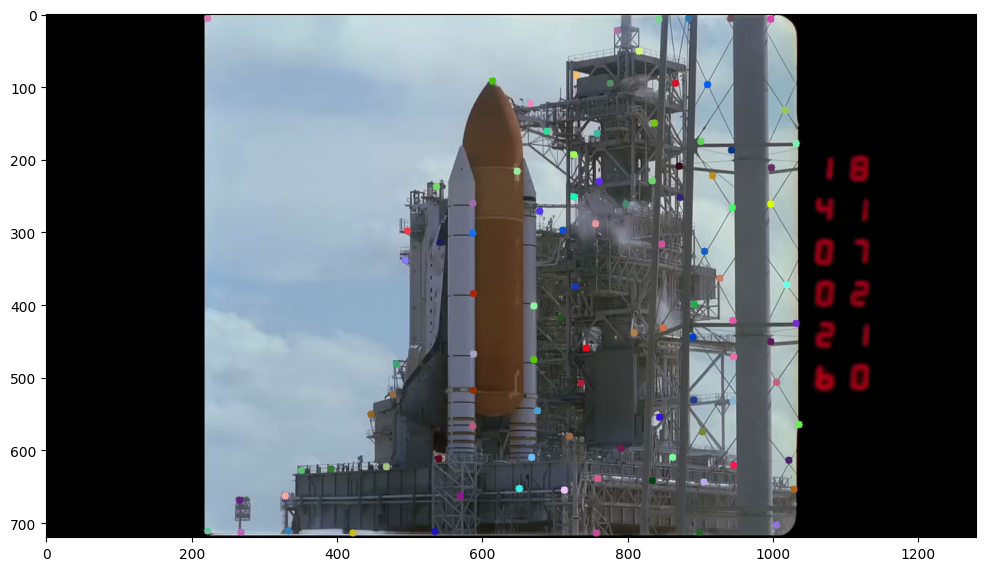

In [35]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
feature_params = dict(maxCorners=100, qualityLevel=0.001, minDistance=40, blockSize=10)

p0 = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
# randomize colors

# cast to int and draw circles
p0 = np.array(p0, dtype=np.int32)
for i in p0:
    x, y = i.ravel()
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.circle(frame, (x, y), 5, color, -1)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [36]:
def baseLoop(source: cv2.VideoCapture):
    frame = None
    status, frame_next = source.read()
    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(
        maxCorners=100, qualityLevel=0.001, minDistance=40, blockSize=10
    )

    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (100, 3))

    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=None, **feature_params)

    mask = np.zeros_like(frame_next)

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()
        # handle
        if not status:
            print("Brak kolejnej klatki")
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
        img = cv2.add(frame_next, mask)

        cv2.imshow("frame_next", img)
        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

        p0 = good_new.reshape(-1, 1, 2)

    source.release()
    cv2.destroyAllWindows()

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def baseLoop(source: cv2.VideoCapture):
    frame = None
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return

    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(
        maxCorners=100, qualityLevel=0.001, minDistance=40, blockSize=10
    )

    lk_params = dict(
        winSize=(20, 20),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (200, 3))

    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=None, **feature_params)

    mask = np.zeros_like(frame_next)

    plt.ion()
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(cv2.cvtColor(frame_next, cv2.COLOR_BGR2RGB))

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            print("End of video.")
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
        img = cv2.add(frame_next, mask)

        # Update the plot in the notebook
        im.set_data(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        clear_output(wait=True)
        display(fig)

        p0 = good_new.reshape(-1, 1, 2)

    plt.ioff()
    plt.show()
    source.release()

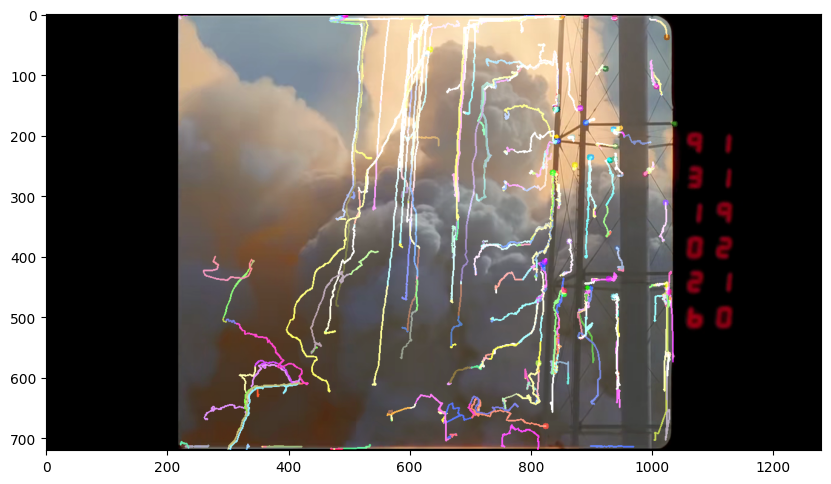

End of video.


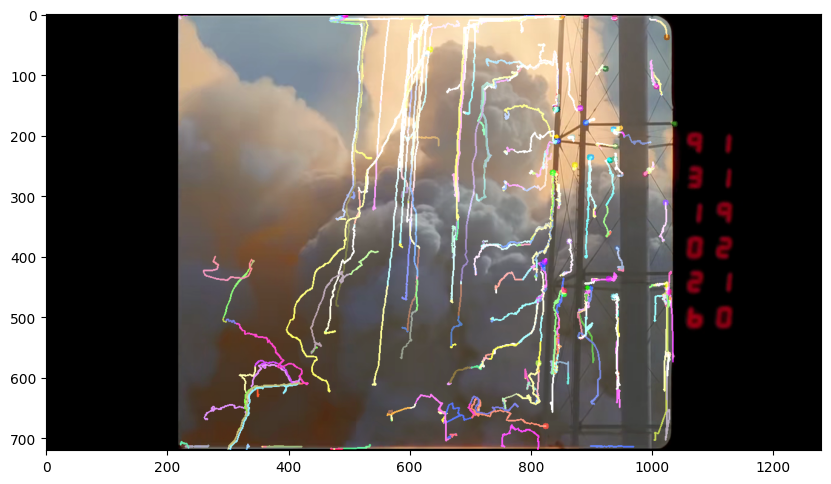

In [38]:
baseLoop(cv2.VideoCapture("dane/shuttle.mp4"))

In [60]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def baseLoopWithAnimation(source: cv2.VideoCapture):
    frames = []
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return

    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(
        maxCorners=100, qualityLevel=0.001, minDistance=40, blockSize=10
    )

    lk_params = dict(
        winSize=(40, 40),
        maxLevel=4,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (200, 3))
    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=None, **feature_params)
    mask = np.zeros_like(frame_next)

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            print("End of video.")
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
        img = cv2.add(frame_next, mask)

        # Append frames for animation
        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        p0 = good_new.reshape(-1, 1, 2)

    # Release the video source
    source.release()

    # Create animation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_axis_off()
    ax.set_title("Optical Flow")
    im = ax.imshow(frames[0])
    fig.tight_layout()

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)

    # Display the animation as HTML5 video
    return HTML(anim.to_html5_video())


# Example usage
source = cv2.VideoCapture("dane/shuttle.mp4")
# skip 4 seconds
source.set(cv2.CAP_PROP_POS_MSEC, 4000)


html_video = baseLoopWithAnimation(source)
source.release()

display(html_video)

End of video.


### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.